### Checking ERA5 winds ###

In [1]:
# Local imports
import os
import sys
import glob
import time
import argparse
import warnings

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import iris
import cftime
import seaborn as sns

In [2]:
%%time

# Load in the ERA5 data
era5_wind_fpath = "/gws/nopw/j04/canari/users/benhutch/ERA5/ERA5_wind_daily_1952_2020.nc"

# load this in with iris
wind_cube = iris.load_cube(era5_wind_fpath, 'si10')

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


CPU times: user 209 ms, sys: 58.7 ms, total: 268 ms
Wall time: 1.1 s


In [3]:
# Extract the lats and lons
lats = wind_cube.coord('latitude').points
lons = wind_cube.coord('longitude').points

# print the min and max lat an dlon
print(f"Latitude: {lats.min()} to {lats.max()}")
print(f"Longitude: {lons.min()} to {lons.max()}")

Latitude: 29.929733276367188 to 89.78487396240234
Longitude: -45.0 to 40.21900177001953


In [23]:
# Set up our constraints
start_date = cftime.datetime(2000, 11, 1, 0, 0, 0)
end_date = cftime.datetime(2001, 2, 28, 23, 59, 59)

# create datetimes between 2000-11-01 and 2001-02-28
dates = pd.date_range("2000-11-01", "2001-02-28", freq="D")

# Set up the lat point
lat = 51.5
lon = 0.0

# Set up the constraint on time
time_constraint = iris.Constraint(time=lambda cell: start_date <= cell <= end_date)

# Find the nearest lat and lon points to the lat and lon we want
closest_lat_idx = np.abs(lats - lat).argmin()
closest_lon_idx = np.abs(lons - lon).argmin()

# Set up the constraint on lat and lon
lat_constraint = iris.Constraint(latitude=lats[closest_lat_idx])
lon_constraint = iris.Constraint(longitude=lons[closest_lon_idx])

In [5]:
# apply the time constrain
wind_cube = wind_cube.extract(time_constraint)

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/common/mixin.py:203: FutureWarning: You are using legacy date precision for Iris units - max precision is seconds. In future, Iris will use microsecond precision - available since cf-units version 3.3 - which may affect core behaviour. To opt-in to the new behaviour, set `iris.FUTURE.date_microseconds = True`.
  warnings.warn(message, category=FutureWarning)


In [10]:
# apply the lat and lon constrain
wind_cube_ts = wind_cube.extract(lat_constraint & lon_constraint)

In [11]:
wind_cube_ts

Si10 (unknown),time
Shape,120
Dimension coordinates,
time,x
Scalar coordinates,
latitude,51.569065 degrees
longitude,0.0001320132 degrees
Attributes,
Conventions,'CF-1.6'
history,'2021-02-05 15:08:48 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf ...'


[cftime.DatetimeProlepticGregorian(2000, 11, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2000, 11, 2, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2000, 11, 3, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2000, 11, 4, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2000, 11, 5, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2000, 11, 6, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2000, 11, 7, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2000, 11, 8, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2000, 11, 9, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2000, 11, 10, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2000, 11, 11, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2000, 11, 12, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(20

(array([11262., 11276., 11292., 11306., 11323., 11337., 11354., 11368.,
        11382.]),
 [Text(11262.0, 0, '2000-11-01'),
  Text(11276.0, 0, '2000-11-15'),
  Text(11292.0, 0, '2000-12-01'),
  Text(11306.0, 0, '2000-12-15'),
  Text(11323.0, 0, '2001-01-01'),
  Text(11337.0, 0, '2001-01-15'),
  Text(11354.0, 0, '2001-02-01'),
  Text(11368.0, 0, '2001-02-15'),
  Text(11382.0, 0, '2001-03-01')])

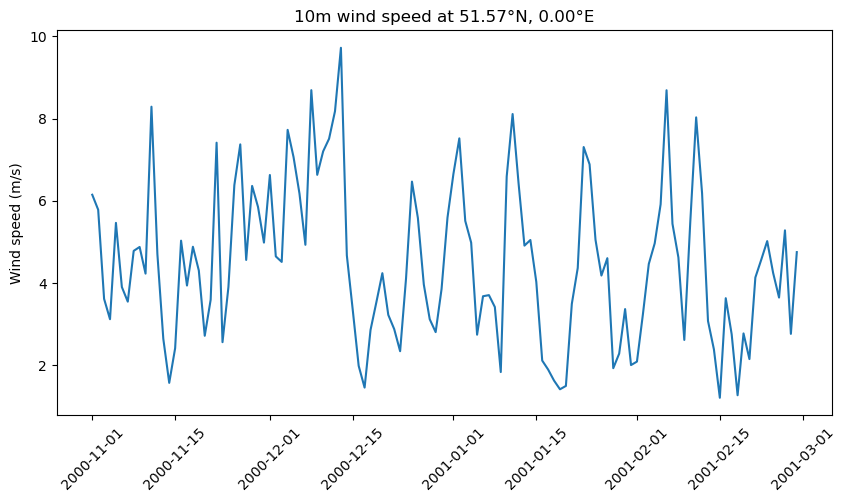

In [27]:
# Plot the time series of this
fig, ax = plt.subplots(figsize=(10, 5))

# Include the lat and lon to 2dp in the title
ax.set_title(f"10m wind speed at {lats[closest_lat_idx]:.2f}°N, {lons[closest_lon_idx]:.2f}°E")

# time:long_name = "time" ;
# time:units = "days since 1952-01-01 00:00:00" ;
# time:calendar = "proleptic_gregorian" ;
times_dt = cftime.num2date(
        wind_cube_ts.coord('time').points,
        units="days since 1952-01-01 00:00:00",
        calendar="proleptic_gregorian"  # Adjust the calendar if needed
    )

# # convert to pandas datetime
# times_dt = pd.to_datetime(times_dt)

# print the times
print(times_dt)

# Plot the time series
ax.plot(dates, wind_cube_ts.data, label='Wind speed')
# ax.set_xlabel('Time')
ax.set_ylabel('Wind speed (m/s)')

# pivot the xlables 45 degrees
plt.xticks(rotation=45)